## Dataset Link : https://www.kaggle.com/alessiocorrado99/animals10

## Importing Necessary libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import requests
from PIL import Image
from io import BytesIO
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.image as mpimg
import io

### Initially after download of data, folders name were in different language so we have to convert it to English

In [9]:
translate = {"cane": "Dog", "cavallo": "Horse", "elefante": "Elephant", "farfalla": "Butterfly", "gallina": "Chicken", "gatto": "Cat", "mucca": "Cow", "pecora": "Sheep", "scoiattolo": "Squirrel", "ragno": "Spider"}

### Defining paths 

In [7]:
main_path = "/content/drive/MyDrive/Smit/animal-10/raw-img/"
test_path = "./Downloaded_Images/"

## Loading images paths and labels into pandas dataframe 

In [11]:
##### Creating Dataframe of images' path #####
# Class 2 has 1446 imges only. To maintain uniformty of counts among different classes, choose only first 1400 images.
foldernames = os.listdir(main_path)
files, files2, target, target2 = [], [], [], []

for i, folder in enumerate(foldernames):
    filenames = os.listdir(main_path + folder);
    count = 0
    for file in filenames:
        if count < 1400:
            files.append(main_path + folder + "/" + file)
            target.append(folder)
            # target.append(translate[folder])
        else:
            files2.append(main_path + folder + "/" + file)
            target2.append(folder)
            # target2.append(translate[folder])
        count += 1

df = pd.DataFrame({'Filepath':files, 'Target':target})
dft = pd.DataFrame({'Filepath':files2, 'Target':target2})
train, test = train_test_split(df, test_size=0.2857, random_state = 0)
#del files, files2, target, target2, df

## Passing to ImageDataGenerator which will also make augmented images and will use to increase model's efficiency

In [12]:
datagen = ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        samplewise_center = True,
        )

datagen_test = ImageDataGenerator(rescale=1./255, samplewise_center = True)

train_flow = datagen.flow_from_dataframe(train, x_col = 'Filepath', y_col = 'Target', target_size=(224, 224), interpolation = 'lanczos', validate_filenames = False)
test_flow = datagen_test.flow_from_dataframe(test, x_col = 'Filepath', y_col = 'Target', target_size=(224, 224), interpolation = 'lanczos', validate_filenames = False)

Found 10000 non-validated image filenames belonging to 10 classes.
Found 4000 non-validated image filenames belonging to 10 classes.


## Creating model architecture

In [13]:
model = applications.VGG16(weights='imagenet', include_top = False, input_shape=(224, 224, 3))

# Setting layers to non-trainable
model.get_layer('block1_conv1').trainable = False
model.get_layer('block1_conv2').trainable = False
model.get_layer('block2_conv1').trainable = False
model.get_layer('block2_conv2').trainable = False

flat1 = tf.keras.layers.Flatten()(model.output)
dropout1 = Dropout(0.1)(flat1)
class1 = tf.keras.layers.Dense(256, activation='relu')(dropout1)
dropout2 = Dropout(0.1)(class1)
output = tf.keras.layers.Dense(10, activation='softmax')(dropout2)
model = Model(inputs = model.inputs, outputs = output)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, verbose = 1, min_delta=0.0001, min_lr = 1e-8)

model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=1e-3, momentum=0.9), metrics = ['accuracy'])
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## See if we have GPU or not 
- I used google collab so GPU was Tesla P4 

In [14]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Training model with GPU - To increase training speed

In [15]:
with tf.device('/device:GPU:0'):
    history = model.fit_generator(train_flow, epochs = 10, validation_data = test_flow, callbacks=[ModelCheckpoint('VGG16.model', monitor='val_acc'), reduce_lr])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
313/313 [==============================] - 4801s 15s/step - loss: 1.0553 - accuracy: 0.6367 - val_loss: 0.7191 - val_accuracy: 0.7682
INFO:tensorflow:Assets written to: VGG16.model/assets
Epoch 2/10
313/313 [==============================] - 198s 633ms/step - loss: 0.4470 - accuracy: 0.8525 - val_loss: 0.3943 - val_accuracy: 0.8763
INFO:tensorflow:Assets written to: VGG16.model/assets
Epoch 3/10
313/313 [==============================] - 195s 622ms/step - loss: 0.3220 - accuracy: 0.8963 - val_loss: 0.2761 - val_accuracy: 0.9080
INFO:tensorflow:Assets written to: VGG16.model/assets
Epoch 4/10
313/313 [==============================] - 196s 626ms/step - loss: 0.2684 - accuracy: 0.9122 - val_loss: 0.2683 - val_accuracy: 0.9133
INFO:tensorflow:Assets written to: VGG16.model/assets
Epoch 5/10
313/313 [==============================] - 195s 623ms/step - loss: 0.2244 - accuracy: 0.9286 - val_loss: 0.2392 - val_accuracy: 0.9305
INFO:tensorflow:Assets written to: VGG16.model/assets
E

## Plotting graphs of accuacy and loss of training and validation dataset

In [ ]:
loss_vals = history.history['loss']
val_loss_vals = history.history['val_loss']
epochs = range(1, len(history.history['accuracy'])+1)

f, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,5))
    
ax[0].plot(epochs, loss_vals,  marker='o', label='Training Loss')
ax[0].plot(epochs, val_loss_vals, marker='o', color = 'green', label='Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best')
ax[0].grid(True)

acc_vals = history.history['accuracy']
val_acc_vals = history.history['val_accuracy']

ax[1].plot(epochs, acc_vals, marker='o', label='Training Accuracy')
ax[1].plot(epochs, val_acc_vals, marker='o', color = 'green', label='Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='best')
ax[1].grid(True)

plt.show()
f.savefig('LossAndAccuracy.eps', format='eps')
plt.close()
del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals

## Saving model for future use

In [16]:
model.save("/content/drive/MyDrive/Smit/animal-10/model.h5")

## Let's validate our model on test data and plot it.

In [2]:
model = tf.keras.models.load_model("./model.h5")

In [3]:
##### Append your urls of animals here for prediction #####
img_url = ['https://pbs.twimg.com/profile_images/378800000532546226/dbe5f0727b69487016ffd67a6689e75a.jpeg',
           'https://i.ytimg.com/vi/UwtTSqTbWzg/maxresdefault.jpg',
           'https://images.unsplash.com/photo-1547399300-7613d8f5f8f1?ixlib=rb-1.2.1&w=1000&q=80',
           'https://www.theartofdoingstuff.com/wp-content/uploads/2014/06/Studio_BlkCpMrnHn_8771_L2.jpg',
           'https://www.k9rl.com/wp-content/uploads/2017/01/Tibetan-Spaniel-dog.jpg',
           'https://static.boredpanda.com/blog/wp-content/uploads/2016/06/I-found-freedom-with-horses-576d2d0804976__880.jpg',
           'https://th.bing.com/th/id/OIP.tOb0fbG7VgjMf2Mj7Sa9igHaEK?pid=Api&rs=1',
           'https://pixfeeds.com/images/topic/2779/1200-2779-butterflies-photo1.jpg',
           'https://th.bing.com/th/id/OIP.GmYkDxsD--csxHFes-lWFwHaDS?pid=Api&rs=1',
           'https://resize.hswstatic.com/w_1024/gif/banana-spider.jpg',
           'https://www.nationalgeographic.com/content/dam/animals/2018/10/waq-animal-caches/01-waq-animal-caches-nationalgeographic_1902487.ngsversion.1539338405615.adapt.1900.1.jpg',
           'https://upload.wikimedia.org/wikipedia/commons/a/ac/Bombay_femelle.JPG',
           'https://th.bing.com/th/id/OIP.1L_D_VUm0lIxk_g1-5uxrgHaEi?pid=Api&rs=1',
           'https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/7_month_old_Suffolk_Ram_Lamb.JPG/1200px-7_month_old_Suffolk_Ram_Lamb.JPG',
           'https://www.guidedogs.org/wp-content/uploads/2019/11/website-donate-mobile.jpg',
           'https://kids.sandiegozoo.org/sites/default/files/2017-09/animal-hero-spiders.jpg',
           'https://media4.s-nbcnews.com/j/newscms/2014_11/241886/140310-smart-elephants-347_5f910b48b8c1a85fc892e9c3d9cc2d00.fit-760w.jpg',
           'https://rollingharbourlife.files.wordpress.com/2013/05/squirrel-nyc-3.jpg',
           'https://media.mnn.com/assets/images/2015/04/butterfly.jpg.990x0_q80_crop-smart.jpg',
           'https://i.imgur.com/drfirIW.jpg'
          ]
! mkdir Downloaded_Images
for i in range(len(img_url)):
    try :
        response = requests.get(img_url[i])
        image_bytes = io.BytesIO(response.content)
        img = PIL.Image.open(image_bytes)
        # img.show()
        img.save("./Downloaded_Images/image" + str(i) + ".png")
    except:
        continue

mkdir: cannot create directory ‘Downloaded_Images’: File exists


In [4]:
classes = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']

In [5]:
def get_output(img):
#     img1 = tf.keras.preprocessing.image.load_img(img, target_size=(224, 224), interpolation='nearest')
#     test_img = tf.keras.preprocessing.image.img_to_array(img1, data_format="channels_last")/255
#     test_img = np.expand_dims(test_img, axis=0)
    img1 = cv2.imread(img)
    temp = Image.fromarray(img1, 'RGB')
    temp = temp.resize((224, 224))
    test_img = np.array(temp) / 255
    test_img = np.expand_dims(test_img, axis=0)
    scores = model.predict(test_img)
    prob = np.max(scores, axis = 1)
    preds = np.argmax(scores, axis = 1)
#     print(f"{prob[0] * 100}% probability of {classes[preds[0]]}")
    return f"{classes[preds[0]]} -- {prob[0] * 100} %"

 ## Let's predict image class and plot it 

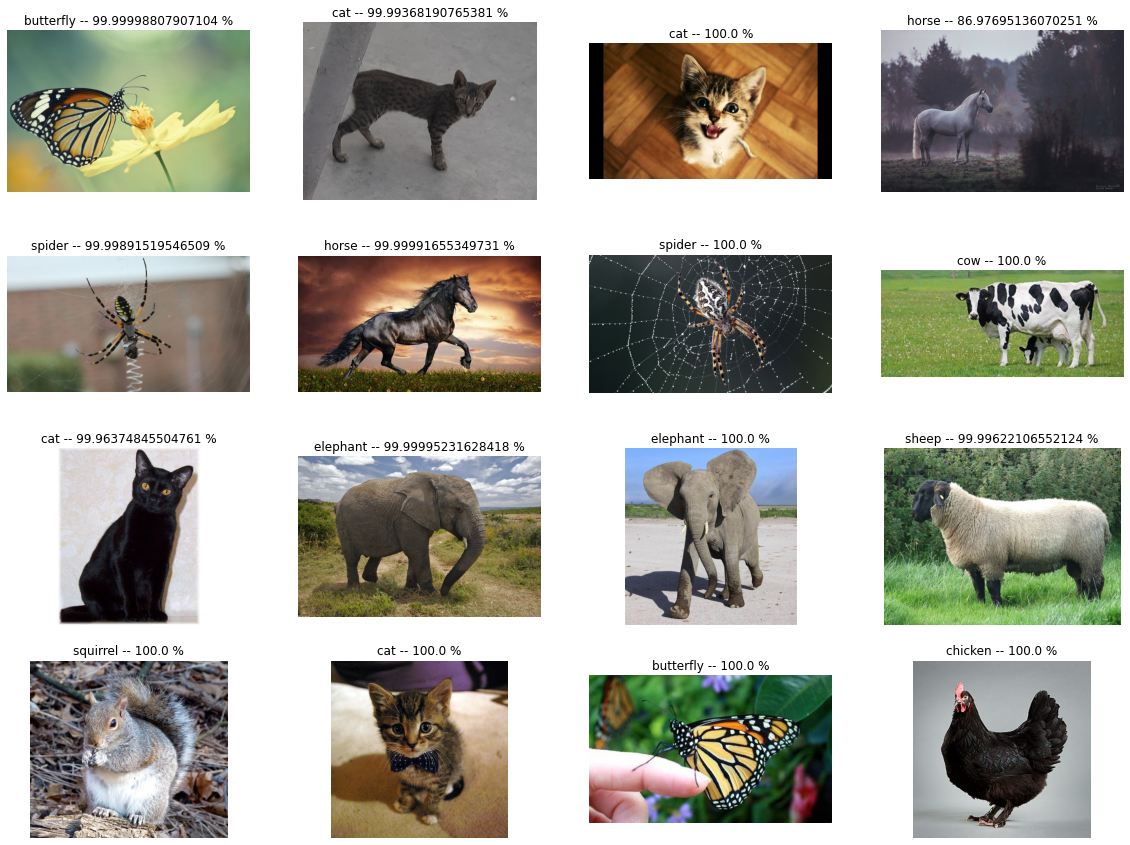

In [8]:
images = [file for file in os.listdir(test_path)]
ind = 0
plt.figure(figsize=(20, 15))
for i in range(1, 17):
    plt.subplot(4, 4, i)
    plt.axis("off")
    if ind > len(images):
        break
    img = mpimg.imread(test_path + images[ind])
    plt.imshow(img)
    plt.title(get_output(test_path + images[ind]))
    ind += 1